In [27]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor': '#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1.5',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12,
}
plt.rcParams.update(dark_style)
plt.rcParams['figure.figsize'] = (15, 10)
pd.options.display.float_format = '{:.2f}'.format

In [28]:
def transform_results(data):
    result_list = []
    for date, details in data.items():
        for auction, auction_data in details["auctions"].items():
            result_list.append({
                "Date": date,
                "Auction": auction,
                "CVaR": auction_data["cvar"] if "cvar" in auction_data else np.nan,
                "SMAPE (%)": auction_data["SMAPE"],
                "Net Volume": auction_data["net_volume_traded"],
                "Volume": auction_data["volume_traded"],
                "Profit": auction_data["profit"],
                "Forecasted Profit": auction_data["forecasted_profit"],
                "Profit Deviation": auction_data["profit"] - auction_data["forecasted_profit"],
            })
    results_df = pd.DataFrame(result_list)
    return results_df

In [29]:
def read_results(power, capacity, risk_averse_factor=None):
    if risk_averse_factor is not None:
        file = f'../Results/stochastic/battery_{power}MW_{capacity}MWh/run_results_l={risk_averse_factor}.json'
    else:
        file = f'../Results/deterministic/battery_{power}MW_{capacity}MWh/run_results.json'
    with open(file) as f:
        return json.load(f)

In [30]:
# power = 10
# capacity = 20
# results_l0 = transform_results(
#     read_results(power, capacity, 0)['results'])
# results_l05 = transform_results(
#     read_results(power, capacity, 0.5)['results'])
# results_l1 = transform_results(
#     read_results(power, capacity, 1)['results'])

### Which strategy is more impacted by forecasting errors?


In [31]:
smape_table_data = {
    ('SMAPE (%)', ''): results_l0.groupby('Auction')['SMAPE (%)'].mean(),
    ('Risk Averse Factor: 0', 'Volume'): results_l0.groupby('Auction')['Volume'].mean(),
    ('Risk Averse Factor: 0', 'Profit Deviation'): results_l0.groupby('Auction')['Profit Deviation'].mean(),
    ('Risk Averse Factor: 0.5', 'Volume'): results_l05.groupby('Auction')['Volume'].mean(),
    ('Risk Averse Factor: 0.5', 'Profit Deviation'): results_l05.groupby('Auction')['Profit Deviation'].mean(),
    ('Risk Averse Factor: 1', 'Volume'): results_l1.groupby('Auction')['Volume'].mean(),
    ('Risk Averse Factor: 1', 'Profit Deviation'): results_l1.groupby('Auction')['Profit Deviation'].mean(),
}
smape_table = pd.DataFrame(smape_table_data)
print(
    """
      1) This shows that a riskier trading strategy leads to higher deviations in realized profits from forecasted profits
         Probably because the riskier trading strategy is more aggressive and trades greater volumes.
    """
)
smape_table

NameError: name 'results_l0' is not defined


    This gives a visual and more clear picture of the deviations in realized profits from forecasted profits.
    


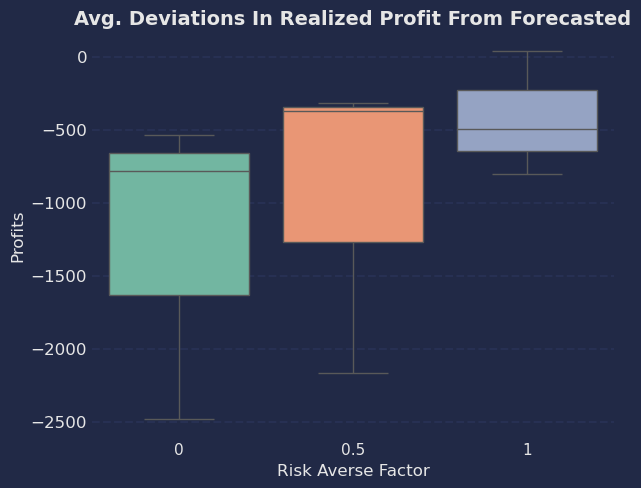

In [7]:
import seaborn as sns

combined = pd.DataFrame({
    "Profit Deviation (l=0)": results_l0.groupby('Auction')['Profit Deviation'].mean(),
    "Profit Deviation (l=0.5)": results_l05.groupby('Auction')['Profit Deviation'].mean(),
    "Profit Deviation (l=1)": results_l1.groupby('Auction')['Profit Deviation'].mean(),
})

plt.figure(figsize=(6, 5))
sns.boxplot(data=combined, palette="Set2")
plt.title('Avg. Deviations In Realized Profit From Forecasted',
          fontsize=14, fontweight='bold')
plt.ylabel('Profits', fontsize=12)
plt.xlabel('Risk Averse Factor', fontsize=12)
plt.xticks([0, 1, 2], ['0', '0.5', '1'], fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
print(
    """
    This gives a visual and more clear picture of the deviations in realized profits from forecasted profits.
    """
)
plt.show()

### Does more risk mean more profit?


In [8]:
profit_table_data = {
    'Risk Averse Factor': ['0', '0.5', '1'],
    'Profit': [
        results_l0['Profit'].sum(),
        results_l05['Profit'].sum(),
        results_l1['Profit'].sum()
    ],
    'Profit Std': [
        results_l0['Profit'].std(),
        results_l05['Profit'].std(),
        results_l1['Profit'].std()
    ],
    # 'Sharpe Ratio': [
    #     results_l0['Profit'].mean() / results_l0['Profit'].std(),
    #     results_l05['Profit'].mean() / results_l05['Profit'].std(),
    #     results_l1['Profit'].mean() / results_l1['Profit'].std()
    # ]
}
profit_table = pd.DataFrame(profit_table_data)
profit_table.set_index('Risk Averse Factor', inplace=True)
print(
    """
    Lower risk means higher AND more stable profits.
    """
)
profit_table


    Lower risk means higher AND more stable profits.
    


,Profit,Profit Std
Risk Averse Factor,,
0,66782.70,11243.67
0.5,56991.17,5750.39
1,73931.67,1494.40


In [9]:
profit_volume_table_data = {
    ('Risk Averse Factor: 0', 'Volume'): results_l0.groupby('Auction')['Volume'].mean(),
    ('Risk Averse Factor: 0', 'Net Volume'): results_l0.groupby('Auction')['Net Volume'].mean(),
    ('Risk Averse Factor: 0', 'Profit'): results_l0.groupby('Auction')['Profit'].mean(),
    ('Risk Averse Factor: 0.5', 'Volume'): results_l05.groupby('Auction')['Volume'].mean(),
    ('Risk Averse Factor: 0.5', 'Net Volume'): results_l05.groupby('Auction')['Net Volume'].mean(),
    ('Risk Averse Factor: 0.5', 'Profit'): results_l05.groupby('Auction')['Profit'].mean(),
    ('Risk Averse Factor: 1', 'Volume'): results_l1.groupby('Auction')['Volume'].mean(),
    ('Risk Averse Factor: 1', 'Net Volume'): results_l1.groupby('Auction')['Net Volume'].mean(),
    ('Risk Averse Factor: 1', 'Profit'): results_l1.groupby('Auction')['Profit'].mean()
}
profit_volume_table = pd.DataFrame(profit_volume_table_data)
profit_volume_table.loc['Total'] = profit_volume_table.sum()
print("""
      1) Here we see that the less risky trading strategies make more profit on average while trading less volume.  
      2) Looking at the net volume traded, we see that the riskier strategy on average uses (relatively and absolutely) more volume for trading between auctions.
         The riskier strategies in this case sell greater volumes in the DA to later buy back in the IDAs than the l=1 strategy. 
      """)
profit_volume_table.style.map(
    lambda x: 'color: pink', subset=pd.IndexSlice['Total', :])


      1) Here we see that the less risky trading strategies make more profit on average while trading less volume.  
      2) Looking at the net volume traded, we see that the riskier strategy on average uses (relatively and absolutely) more volume for trading between auctions.
         The riskier strategies in this case sell greater volumes in the DA to later buy back in the IDAs than the l=1 strategy. 
      


In [10]:
profit_table_data = {
    ('Risk Averse Factor: 0', 'Profit', 'std'): results_l0.groupby('Auction')['Profit'].std(),
    ('Risk Averse Factor: 0', 'Profit', 'mean'): results_l0.groupby('Auction')['Profit'].mean(),
    ('Risk Averse Factor: 0.5', 'Profit', 'std'): results_l05.groupby('Auction')['Profit'].std(),
    ('Risk Averse Factor: 0.5', 'Profit', 'mean'): results_l05.groupby('Auction')['Profit'].mean(),
    ('Risk Averse Factor: 1', 'Profit', 'std'): results_l1.groupby('Auction')['Profit'].std(),
    ('Risk Averse Factor: 1', 'Profit', 'mean'): results_l1.groupby('Auction')['Profit'].mean(),
}
profit_table = pd.DataFrame(profit_table_data)
print(
    """
      1) The riskier the trading strategy, the higher the standard deviation in profits. 
         l=0 strategy has significantly higher std in profits than the l=1 strategy in each auction.
    """
)
profit_table


      1) The riskier the trading strategy, the higher the standard deviation in profits. 
         l=0 strategy has significantly higher std in profits than the l=1 strategy in each auction.
    


Risk Averse Factor: 0          Risk Averse Factor: 0.5          \
                       Profit                           Profit           
                          std     mean                     std    mean   
Auction                                                                  
DA                   11429.31  3520.79                 5916.80  138.83   
IDA1                 14323.43    84.25                 6960.64 1703.17   
IDA2                  6205.32 -1450.77                 4011.63   -3.58   

        Risk Averse Factor: 1          
                       Profit          
                          std    mean  
Auction                                
DA                    1696.15 1228.28  
IDA1                  1236.44 1081.73  
IDA2                  1275.95   74.88

## CVaR


In [11]:
cvar_table_data = {
    ('Risk Averse Factor: 0', 'CVaR'): results_l0.groupby('Auction')['CVaR'].mean(),
    ('Risk Averse Factor: 0', 'Std. Profit'): results_l0.groupby('Auction')['Profit'].std(),
    ('Risk Averse Factor: 0.5', 'CVaR'): results_l05.groupby('Auction')['CVaR'].mean(),
    ('Risk Averse Factor: 0.5', 'Std. Profit'): results_l05.groupby('Auction')['Profit'].std(),
    ('Risk Averse Factor: 1', 'CVaR'): results_l1.groupby('Auction')['CVaR'].mean(),
    ('Risk Averse Factor: 1', 'Std. Profit'): results_l1.groupby('Auction')['Profit'].std(),
}
cvar_table = pd.DataFrame(cvar_table_data)
print(
    """
    1) The high-risk strategy has a much higher CVaR, indicating that it is more exposed to potential large losses in extreme scenarios.
    2) High-risk strategies show much higher standard deviations, meaning that the profits fluctuate more and are less predictable
    => The table clearly shows that increasing risk aversion reduces the exposure to extreme losses and stabilizes profits
    """
)
cvar_table


    1) The high-risk strategy has a much higher CVaR, indicating that it is more exposed to potential large losses in extreme scenarios.
    2) High-risk strategies show much higher standard deviations, meaning that the profits fluctuate more and are less predictable
    => The table clearly shows that increasing risk aversion reduces the exposure to extreme losses and stabilizes profits
    


Risk Averse Factor: 0             Risk Averse Factor: 0.5              \
                         CVaR Std. Profit                    CVaR Std. Profit   
Auction                                                                         
DA                    4260.65    11429.31                  135.75     5916.80   
IDA1                  3034.93    14323.43                  105.90     6960.64   
IDA2                      NaN     6205.32                     NaN     4011.63   

        Risk Averse Factor: 1              
                         CVaR Std. Profit  
Auction                                    
DA                      17.60     1696.15  
IDA1                   169.18     1236.44  
IDA2                      NaN     1275.95

### Model comparison


In [20]:
power, capacity = 10, 20

In [32]:
deterministic_model = transform_results(
    read_results(power, capacity)['results'])
stochastic_model = transform_results(
    read_results(power, capacity, 1)['results'])

In [33]:
models = {
    "Deterministic": deterministic_model,
    "Stochastic": stochastic_model
}

comparison_data = {
    'Total Profit': [
        model["Profit"].sum() for model in models.values()
    ],
    'Daily Mean Profit': [
        model.groupby('Date')['Profit'].sum().mean() for model in models.values()
    ],
    'Daily Profit Std': [
        model.groupby('Date')['Profit'].sum().std() for model in models.values()
    ],
    'Min Profit': [
        model.groupby('Date')['Profit'].sum().min() for model in models.values()
    ],
    'Mean Daily Volume Traded': [
        model.groupby('Date')['Volume'].sum().mean() for model in models.values()
    ],
    'Mean Daily Net Volume Traded': [
        model.groupby('Date')['Net Volume'].sum().mean() for model in models.values()
    ],
    'Mean Daily Profit Deviation': [
        model.groupby('Date')['Profit Deviation'].sum().mean() for model in models.values()
    ],
}

comparison_table = pd.DataFrame(
    comparison_data, index=models.keys())
comparison_table

,Total Profit,Daily Mean Profit,Daily Profit Std,Min Profit,Mean Daily Volume Traded,Mean Daily Net Volume Traded,Mean Daily Profit Deviation
Deterministic,67660.00,2182.58,801.26,956.80,434.52,1.94,-542.35
Stochastic,14427.50,465.40,783.26,-1546.97,425.33,4.64,-585.88


In [34]:
stochastic_model

,Date,Auction,CVaR,SMAPE (%),Net Volume,Volume,Profit,Forecasted Profit,Profit Deviation
0,2023-12-01,DA,0.00,8.96,13.92,179.68,-1007.68,-1223.71,216.03
1,2023-12-01,IDA1,0.00,4.79,38.93,202.79,-8841.01,-8475.87,-365.14
2,2023-12-01,IDA2,NaN,4.02,-52.85,90.27,11332.97,12174.98,-842.01
3,2023-12-02,DA,0.00,7.68,2.95,228.75,515.89,336.13,179.76
4,2023-12-02,IDA1,-0.00,10.41,41.94,215.79,-6267.37,-7290.30,1022.92
...,...,...,...,...,...,...,...,...,...
88,2023-12-30,IDA1,0.00,30.73,32.42,234.23,-2771.76,-6436.80,3665.04
89,2023-12-30,IDA2,NaN,46.40,-42.62,82.62,3884.74,9226.85,-5342.12
90,2023-12-31,DA,0.00,42.62,-80.00,234.47,5169.80,2613.72,2556.07
91,2023-12-31,IDA1,0.00,17.09,110.00,190.55,-6559.37,-5766.08,-793.28
